#### QAPP ID: I-CCED-0032994-QP-1-0
#### Author: Matthew Adams
#### Principal Investigator: Grace Patlewicz
#### Last Modified Jun 27 2022

#### Predicting LD50 values with AIM fingerprints

Let import our datasets and start looking at them:

In [1]:
#Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from collections import Counter
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import re
#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import openpyxl
import os

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP + 'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [3]:
#Here we are going to use openpyxl to open these worksheets

CMO = pd.concat([pd.read_excel(raw_dir+'smi_acute.xlsx', sheet_name = 'first'), pd.read_excel(raw_dir+'smi_acute.xlsx', sheet_name = 'last')], axis =0).drop(['INPUT','FOUND_BY'],axis=1)



In [4]:
#View the first few lines of the dataset

CMO.head()

,DTXSID,PREFERRED_NAME,SMILES,QSAR_READY_SMILES
0,DTXSID5020281,1-Chloro-4-nitrobenzene,[O-][N+](=O)C1=CC=C(Cl)C=C1,[O-][N+](=O)C1=CC=C(Cl)C=C1
1,DTXSID8020961,4-Nitroaniline,NC1=CC=C(C=C1)[N+]([O-])=O,NC1=CC=C(C=C1)[N+]([O-])=O
2,DTXSID0021834,4-Nitrophenol,OC1=CC=C(C=C1)[N+]([O-])=O,OC1=CC=C(C=C1)[N+]([O-])=O
3,DTXSID2044347,4'-Methoxyacetophenone,COC1=CC=C(C=C1)C(C)=O,COC1=CC=C(C=C1)C(C)=O
4,DTXSID4025745,4-Nitrobenzyl chloride,[O-][N+](=O)C1=CC=C(CCl)C=C1,[O-][N+](=O)C1=CC=C(CCl)C=C1


In [5]:
#check out the shape of the dataset

CMO.shape
#CMO.to_csv('dtx_smiles.csv')

(7011, 4)

In [6]:
#Filter to remove records where no SMILES are available

CHM0 = CMO[CMO["SMILES"]!='-']
CHM0.head()

,DTXSID,PREFERRED_NAME,SMILES,QSAR_READY_SMILES
0,DTXSID5020281,1-Chloro-4-nitrobenzene,[O-][N+](=O)C1=CC=C(Cl)C=C1,[O-][N+](=O)C1=CC=C(Cl)C=C1
1,DTXSID8020961,4-Nitroaniline,NC1=CC=C(C=C1)[N+]([O-])=O,NC1=CC=C(C=C1)[N+]([O-])=O
2,DTXSID0021834,4-Nitrophenol,OC1=CC=C(C=C1)[N+]([O-])=O,OC1=CC=C(C=C1)[N+]([O-])=O
3,DTXSID2044347,4'-Methoxyacetophenone,COC1=CC=C(C=C1)C(C)=O,COC1=CC=C(C=C1)C(C)=O
4,DTXSID4025745,4-Nitrobenzyl chloride,[O-][N+](=O)C1=CC=C(CCl)C=C1,[O-][N+](=O)C1=CC=C(CCl)C=C1


In [7]:
AIM_FP = pd.read_csv(raw_dir+'CHM0_apr14_aim.txt',sep=';')
AIM_FP = AIM_FP[AIM_FP['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']
AIM_FP = AIM_FP.iloc[:,0:-2]
AIM_FP = AIM_FP.set_index('M_NAME').rename_axis(index=None)

print(AIM_FP.shape)
# # Remove duplicates (FOR AIM)
## WARNING:
## 5/5/22 -- this MIGHT not working properly 
# ex: 341C and 71E are the same
## checking the duplicates 


col_names = []
for i in AIM_FP.columns:
    col_names.append(i.split('.')[0])    
mylist = Counter(col_names)
duplicate_list= {key: value for key, value in mylist.items() if value > 1}

len_dict = len(duplicate_list)
sum_dict = sum(duplicate_list.values())
print(f'{sum_dict-len_dict} columns to be removed')

cols = []
for i in AIM_FP.columns:
    if i.split('.')[0] in duplicate_list.keys():
        cols.append(i)
        
df_dupes =AIM_FP[cols].copy()
for i,col in enumerate(df_dupes):
    col_1 = df_dupes.iloc[:,i].name.split('.')[0]
    # Match columns which are duplicates (e.g. Mercury [Measured] and Mercury [Measured].1 ) by name
    for j, col2 in enumerate(df_dupes):
        col_2 = df_dupes.iloc[:,j].name.split('.')[0]
            # If match, then column values will be updated to maximum value across the two columns for each row
        if col_1 == col_2:
            df_dupes[col] = df_dupes[[col,col2]].max(axis=1)
    
    
    
n_before = AIM_FP.shape[1]
for col in df_dupes:
    # Remove duplicate columns which are not the first (indicated by ending in  .[1-9])
    if re.search('\.[1-9]$',col) is not None:
        AIM_FP = AIM_FP.drop(columns=[col])
    else:
        AIM_FP[col] = df_dupes[col]
    
    

n_after = AIM_FP.shape[1]

print(f'{n_before-n_after} columns removed')


AIM_FP = AIM_FP.dropna(axis=1)
print(AIM_FP.shape)
AIM_FP.head()
AIM_FP.to_pickle(processed_dir+'AIM_FP.pkl')

(6972, 902)
117 columns to be removed
117 columns removed
(6972, 785)


In [8]:
MOLS = dict(zip(CHM0['DTXSID'], CHM0['SMILES']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
Morgan_FP = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,2048)) for i in MOLS.values()])
Morgan_FP.index=MOLS.keys()
Morgan_FP.columns = ['mrgn_%d'%i for i in Morgan_FP.columns]

[17:31:14] Explicit valence for atom # 3 O, 3, is greater than permitted


In [9]:
Toxprint_FP = pd.read_csv(raw_dir+'CHM0_apr1_tox.txt',sep=';')
Toxprint_FP = Toxprint_FP[Toxprint_FP['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']
Toxprint_FP = Toxprint_FP.iloc[:,0:-2]
Toxprint_FP = Toxprint_FP.set_index('M_NAME').rename_axis(index=None)
Toxprint_FP.to_pickle(processed_dir+'Toxprint_FP.pkl')
Toxprint_FP.head()


,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,bond:C#N_cyano_cyanohydrin,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2044347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID4025745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

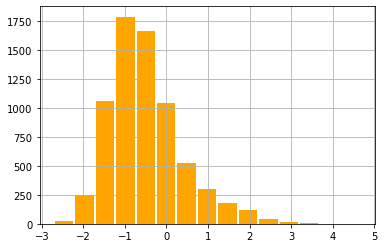

In [10]:
#Import LD50 data and view its distribution

POD0 = pd.read_csv(raw_dir+'small_acute_processed.csv').set_index('dsstox_sid')
POD0.LD50_LM.hist(bins=15,rwidth=0.9,color='orange')

In [11]:
# To run AIM, set FP0 to AIM_FP instead...

FP0_list = [AIM_FP,Toxprint_FP,Morgan_FP]

# Set FP0 to whichever fingerpritn you want by changing the list index.
FP0 = FP0_list[0]


In [12]:
FP0.shape

(6972, 785)

In [13]:

I = FP0.index.intersection(POD0.index)
X,Y = FP0.loc[I],POD0.loc[I,'LD50_LM']

In [14]:
POD0.head()

,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,casrn,mol_weight,LD50_LM
dsstox_sid,,,,,,,,
DTXSID5020281,False,False,460.0,2.0,4.0,100-00-5,157.550003,-0.465339
DTXSID8020961,False,False,750.0,3.0,4.0,100-01-6,138.126007,-0.734786
DTXSID0021834,False,False,170.0,2.0,3.0,100-02-7,139.110001,-0.087091
DTXSID2044347,False,False,1720.0,3.0,4.0,100-06-1,150.177002,-1.058925
DTXSID4025745,False,False,1809.0,3.0,4.0,100-14-1,171.580002,-1.022972


In [15]:
Y

DTXSID5020281    -0.465339
DTXSID8020961    -0.734786
DTXSID0021834    -0.087091
DTXSID2044347    -1.058925
DTXSID4025745    -1.022972
                    ...   
DTXSID3044752    -0.184418
DTXSID80244288    1.942702
DTXSID0022143    -0.283519
DTXSID6020303    -0.579302
DTXSID2025395    -0.719993
Name: LD50_LM, Length: 6972, dtype: float64

# Import genra modules

In [16]:
X.shape

(6972, 785)

In [17]:
X.head()

,CH3 [aliphatic carbon],CH2 [aliphatic carbon],CH [aliphatic carbon],"C [aliphatic carbon No H, not tert]",=CH2 [olefinic carbon],=CH or =C [olefinc carbon],#C [acetylenic carbon],"OH [hydroxy, aliphatic attach]","O [oxygen, aliphatic attach]",NH2 [aliphatic attach],...,N CH=N OH [oxime type] correction,Ring rx: OH ortho to C=N N carbon,=C (C#N) C#N [dicyano] correction,Aromatic nitrogen C C(=S) N struct corr.,Cyclic ketoxime(>C=N OH) [1 olefin attach],C=N O sulfur(aliphatic) [iminoxy] correc,S N( C(=O) C) C(=O) C struct correction,Sulfur(+4) charged halide type,Ring rx: S=P(O)(O)O / 5 mem (2 nitrogen),O=P( O)( O) C OH correction
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2044347,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID4025745,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
import genra

In [19]:
from genra.rax.skl.reg import GenRAPredValue

In [20]:
from sklearn.metrics import make_scorer,explained_variance_score,roc_auc_score,r2_score,f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [21]:
GP1 = GenRAPredValue(algorithm='brute')

params={'n_neighbors': range(1,15),
        'metric':['jaccard','euclidean']
       }


Grid3= GridSearchCV(estimator=GP1,param_grid=params,
                    n_jobs=-1,cv=5,
                    verbose=1,
                    scoring=make_scorer(r2_score))


Best3=Grid3.fit(X.values,Y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


Best: 0.3607160002840524 {'metric': 'jaccard', 'n_neighbors': 8}


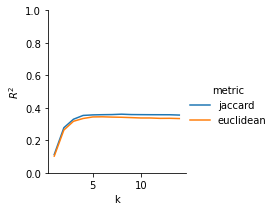

In [24]:
P = pd.DataFrame(Best3.cv_results_['params'])
P.insert(2,'score_mn',Best3.cv_results_['mean_test_score'])
P.insert(3,'score_std',Best3.cv_results_['std_test_score'])

g=sns.FacetGrid(P,hue='metric')
g.map(plt.plot,'n_neighbors','score_mn')
g.set(ylim=(0,1.0),xlabel='k',ylabel='$R^2$')
g.add_legend()
print("Best:", Best3.best_score_,Best3.best_params_)

In [25]:
#P

In [26]:
from sklearn.model_selection import cross_val_predict,LeaveOneOut, cross_validate
from genra.rax.skl.reg import *


GC1 = GenRAPredValue(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=-1)

Loo = LeaveOneOut()
Loo.get_n_splits(X.values)

Yp = cross_val_predict(GC1,X.values,Y,cv=LeaveOneOut(),n_jobs=-1,verbose=True)
#cv_results = cross_validate(GC1, X.values, Y, cv = Loo, n_jobs = -1, scoring=make_scorer(r2_score), return_train_score = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/anaconda3/envs

In [34]:
Yp.shape

(6972,)

In [28]:
Perf1 = pd.DataFrame(dict(Y_true=Y,Y_pred=Yp))
Perf1 = Perf1[Perf1['Y_pred'].notna()]
Perf1['Diff'] = np.abs((Perf1['Y_true']-Perf1['Y_pred']))


Perf1

,Y_true,Y_pred,Diff
DTXSID5020281,-0.465339,-0.329968,0.135371
DTXSID8020961,-0.734786,-0.842910,0.108124
DTXSID0021834,-0.087091,-0.569759,0.482668
DTXSID2044347,-1.058925,-1.143505,0.084580
DTXSID4025745,-1.022972,-0.786114,0.236858
...,...,...,...
DTXSID3044752,-0.184418,-0.580946,0.396529
DTXSID80244288,1.942702,0.015562,1.927141
DTXSID0022143,-0.283519,-1.318011,1.034492
DTXSID6020303,-0.579302,-0.640617,0.061316


In [29]:
print("$R^2$ score= {:.3f}\nRMSE={:0.3f}\n"\
              .format(r2_score(Perf1['Y_true'],Perf1['Y_pred']),
                      np.sqrt(((Perf1['Y_true']-Perf1['Y_pred'])**2).mean())))


$R^2$ score= 0.434
RMSE=0.663



In [30]:
Perf1['residual']=(Perf1['Y_pred']-Perf1['Y_true'])
Perf1['mse']=(Perf1['Y_true']-Perf1['Y_pred'])**2

In [35]:
Perf1.shape

(6968, 5)

In [82]:
cols = {k:v for k,v in enumerate(AIM_FP.columns)}

In [95]:
FPs = []
for i,group in AIM_FP.iterrows():
    a = np.where(group.values ==1)
    b = [cols[e] for e in a[0]]
    FPs.append([i,b])
        

In [100]:
aim_list = pd.DataFrame(FPs, columns = ['dtxsid', 'aim_list'])

In [103]:
aim_predictions = pd.merge(Perf1, aim_list, left_on = Perf1.index, right_on = 'dtxsid', how = 'left')

In [104]:
aim_predictions.to_csv(processed_dir+'aim_predictions_genra.csv')

<Figure size 864x720 with 0 Axes>

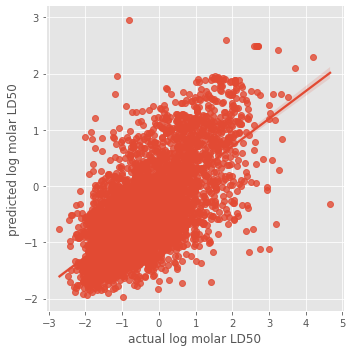

In [30]:
#import seaborn as sns

#sns.set(style='whitegrid',font_scale=2.0)
plt.style.use('ggplot')
plt.figure(figsize = (12,10))

g = sns.lmplot(x='Y_true',y='Y_pred', data=Perf1)
g.set_axis_labels("actual log molar LD50", "predicted log molar LD50")
#plt.xlabel('actual log molar LD50', size = 15)
#plt.ylabel('predicted log molar LD50', size = 15);
#txt = "$R^2$ score= {:.3f}\nRMSE={:0.3f}\n"\
#              .format(r2_score(Perf1['Y_true'],Perf1['Y_pred']),
#                      np.sqrt(((Perf1['Y_true']-Perf1['Y_pred'])**2).mean()))
 

#for p in g.axes:
#    p[0].text(-2, 2, txt, horizontalalignment='left', size='large', color='black', weight='semibold')

In [ ]:
# Extract neighbours for a specific chemical: 'DTXSID5020281'

In [ ]:
from genra.rax.viz.nn import *

In [ ]:
CHM_info = FP0.reset_index().rename(columns = {'index': 'DTXSID'}).merge(CHM0, on = 'DTXSID')

In [ ]:
CHM0.head()

In [ ]:
CHM_info = CHM_info.set_index('DTXSID')

In [ ]:
CHM_info.index.rename('ID', inplace = True)

In [ ]:
CHM_info.rename(columns = {'SMILES': 'smiles', 'PREFERRED_NAME': 'chemical_name'}, inplace = True)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
ax.set_axis_off()
ax.set_xlim(-600,600)
ax.set_ylim(-600,600)
target_id = 'DTXSID8058031'
GV = GenRAViewNN(rs=1.2,lw=0.2,ax=ax,th_tot=1.9*math.pi,
                 chm_name_font_size=8,
                   chm_sz=(150,150),r_min=320)
GV.loadData(FP0,np.ones(FP0.shape[0]),Info=CHM_info)
GV.draw(target_id,k=8)

In [ ]:
#target_id = 'DTXSID5020281'

In [ ]:
# The nearest neighbours of target_id: 'DTXSID5020281' are found by inspecting the GV object:

GV._NNi.ID

In [ ]:
#Look at the nearest neighbours from the chemical set

CHM0[CHM0['DTXSID'].isin(GV._NNi.ID)]

In [ ]:
I = Y.index.intersection(GV._NNi.ID)

In [ ]:
Y_i  =Y.loc[I]

In [ ]:
# LD50_LM of neighbours
Y_i

In [ ]:
X_i = X.loc[I]

In [ ]:
X_i

In [ ]:
# Identify chem FP for target chem

In [ ]:
X_t = X_i.loc[target_id]

In [ ]:
# Make prediction using the neighbours identified

In [ ]:
GP_i = GenRAPredValue(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=-1)

In [ ]:
GP_i.fit(X_i[1:], Y_i[1:])

In [ ]:
Y_t = GP_i.predict([X_t])

In [ ]:
#Predicted value of target chemical
Y_t

#### Computing the similarity weighted activity manually

In [ ]:
from scipy.spatial.distance import pdist, squareform

D_mgrn = pd.DataFrame(squareform(pdist(X, 'jaccard')), columns = X.index, index = X.index)
S_mgrn = 1-D_mgrn
S_mgrn.head()

In [ ]:
target_chm = S_mgrn.DTXSID5020281.values

In [ ]:
target_chm 

In [ ]:
S_mgrn[S_mgrn.index == 'DTXSID5020281']

In [ ]:
ids_chem = {i:x for i, x in enumerate(S_mgrn.index)}

In [ ]:
temp_chem = np.argpartition(-target_chm, 9)
chem_nn = temp_chem[:9]
print(chem_nn)


In [ ]:
target_chm[chem_nn]

In [ ]:
nn_chem = []
for x in chem_nn:
    nn_chem.append(ids_chem[x])

In [ ]:
mydict = {k:v for k,v in list(zip(nn_chem,target_chm[chem_nn]))}

In [ ]:
Yb = Y.reset_index()

In [ ]:
Yb.columns = ['dtxsid', 'LD50_LM']

In [ ]:
Yh =Yb[Yb.dtxsid.isin(nn_chem)]

In [ ]:
Yh['Jaccard'] = Yh['dtxsid'].map(mydict)

In [ ]:
Yh

In [ ]:
def wtavg(df):
    sim = df.Jaccard
    acts = df.LD50_LM
    return np.sum(acts.values * sim.values)/np.sum(sim.values)


In [ ]:
# Predicted similarity weighted activity of target matches!!

In [ ]:
wtavg(Yh[Yh['dtxsid'] != 'DTXSID5020281'])

In [ ]:
# Checking neighbours identified manually

In [ ]:
Yh.dtxsid.tolist()

In [ ]:
Y_i.reset_index()['index'].tolist()

In [ ]:
assert (Y_i.reset_index()['index'].tolist() ==  Yh.dtxsid.tolist())

In [ ]:
# Neighbours identified are equal

In [ ]:
[e for e in Y_i.reset_index()['index'].tolist() if e not in Yh.dtxsid.tolist()]